# Solving nonogram puzzles in CPMpy

The nonogram puzzle consists of coloring a set of squares.
The nonogram puzzle board consists of a recangle of squares.
The goal of the puzzle is to fill in the squares according to some constraints such that a picture is displayed.
For each row in the grid, a sequence of "colored squares" is indicated using a tuple of integers.
Each integer represents the length of a "colored group". 
Between each colored group one or more uncolored squares should be present in the solution of the problem.

For example: when playing on a 10x10 board, the tuple (2,1,4) for a given row has the following solution: BBWBWWBBBB but also BBWWBWBBBB.

The same rules apply to each column. The solution of a nonogram is unique.


In [1]:
import urllib
from PIL import Image
import requests
import numpy as np
from io import BytesIO



# get picture from web
# for reasonable runtime, limit to size +-200x200 pixels
url = "https://github.com/CPMpy/cpmpy/blob/directconstraint_only/examples/pixil-frame.png?raw=true" # T-rex
# url = "https://pbs.twimg.com/profile_images/711593363624095747/lJV3XX-H_400x400.jpg" # Alan Turing

r = requests.get(url, stream=True)
img = np.array(Image.open(BytesIO(r.content)))

# convert to binary
img = img.mean(axis=2)
thresh = (img.max() - img.min()) / 2
img[img < thresh] = 0
img[img >= thresh] = 1

In [2]:
# convert image to nonogram clues
row_rules = []
for row in img:
    idx = np.concatenate(([0],np.flatnonzero(row[:-1]!=row[1:])+1,[row.size]))
    out = zip(row[idx[:-1]],np.diff(idx))
    row_rules.append([nb for (val, nb) in out if val == 1])

col_rules = []
for col in img.T:
    idx = np.concatenate(([0],np.flatnonzero(col[:-1]!=col[1:])+1,[col.size]))
    out = zip(col[idx[:-1]],np.diff(idx))
    col_rules.append([nb for (val, nb) in out if val == 1])

We can represent each row (resp column) as an automaton.
For example, the rule (1,2) for a board with dimension 5 corresponds to the following automaton:
![automaton](https://github.com/CPMpy/cpmpy/blob/directconstraint_only/examples/automaton.png?raw=true)

In [3]:
def transition_function(pattern):
    """
        Pattern is a vector containing the lengths of blocks with value 1
        Returns transition function with format (start_state, char, end_state)
    """
    func = []
    n_states = 0
    for block_length in pattern:
        if block_length == 0:
            continue
        # can stay in same state for emtpy cell
        func += [(n_states, 0, n_states)]
        # group contains exact number of filled cells
        for _ in range(block_length):
            func += [(n_states, 1, n_states+1)]
            n_states += 1
        # go to next subgroup after group is finished
        func += [(n_states, 0, n_states+1)]
        n_states += 1

    func += [(n_states, 0, n_states)]
        # line can end empty or filled
    return func, [n_states-1,n_states]

In [4]:
from cpmpy import *

def nonogram(row_rules, col_rules, **kwargs):

    model = Model()

    n_rows, n_cols = len(row_rules), len(col_rules)
    board = intvar(0,1,shape=(n_rows,n_cols), name="board")

    # add row constraints
    for r, pattern in enumerate(row_rules):
        automaton_func, final_states = transition_function(pattern)
        # OR-tools version of the 'Regular' constraint
        model += DirectConstraint(
            "AddAutomaton",
            (board[r], 0, final_states, automaton_func),
            novar=[1,2,3],
        )

    # add column constraints
    for c, pattern in enumerate(col_rules):
        automaton_func, final_states = transition_function(pattern)
        # OR-tools version of the 'Regular' constraint
        model += DirectConstraint(
            "AddAutomaton",
            (board[:,c], 0, final_states, automaton_func),
            novar=[1,2,3],
        )

    return model, (board,)

In [5]:
model, (board,) = nonogram(row_rules, col_rules)

# Depending on the size of the image, solving may take a long time
assert model.solve(solver="ortools")

/var/folders/b_/fbfx8w992m9_7pm37zz2vmg00000gn/T/ipykernel_59986/2290791997.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


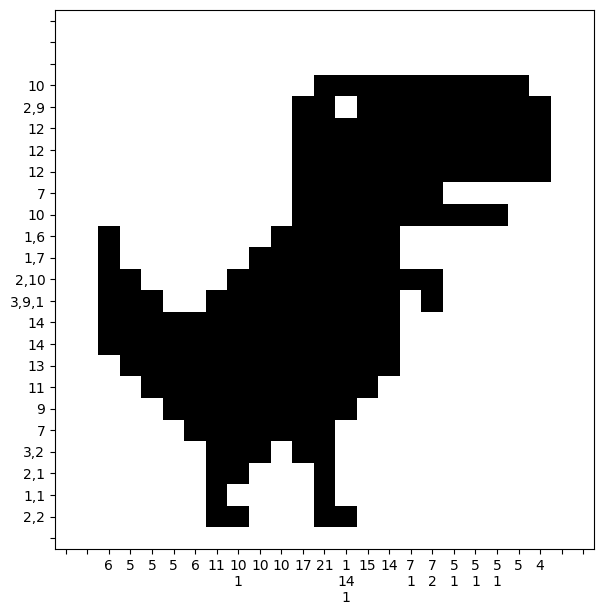

In [6]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1,figsize=(7,7))

ax.imshow(board.value(),cmap="binary")

# show nonogram rules? (only for small images)
ax.set_xticks(range(len(col_rules)), ["\n".join([str(i) for i in r]) for r in col_rules])
ax.set_yticks(range(len(row_rules)), [",".join([str(i) for i in r]) for r in row_rules])

fig.show()